# Deepmind PerceiverIO on GPU

## Introduction
This notebook presents a demonstration of how to run the PercieverIO 
model on GPU using any of the following backends currently supported by ivy (numpy, torch, tensorflow and JAX). 
To find out more about ivy please feel free to checkout the ivy repo https://github.com/unifyai/ivy as well as the docs https://lets-unify.ai/ivy/index.html. Contributions are highly welcomed and you can interact with our community as well on discord https://discord.com/invite/G4aR9Q7DTN. 

### Install Python3.8 and setup the kernel
NOTE: After running the cell below, you'll need to restart the runtime for the newly installed kernel to work.

In [ ]:
# Step1
!printf "#Step1 start Download python3.8packages(tar.gz) of Share File from GoogleDrive\n"
!printf "10_wfp1U4rMzc20eiGNrdQa9V2S9ByJwV" > ./FILE_ID ;\
 printf "wget  -O `cat ./FILE_ID`.tar.gz \"https://drive.google.com/uc?export=download&id=`cat ./FILE_ID`&confirm=t&"|tee  ./FILE_ID_WGET_CMD  ;\
  printf "`wget -q "https://drive.google.com/uc?export=download&id=\`cat ./FILE_ID\`" -O - | perl -pe 's/\r*\n//g' | perl -pe 's/^.*(uuid\=[^\"]+)\".*$/${1}/g'`"|tee -a ./FILE_ID_WGET_CMD  ;\
    printf "&uc-download-link=Download anyway\"" |tee -a ./FILE_ID_WGET_CMD ;\
      /bin/bash ./FILE_ID_WGET_CMD
!printf "#Step1 End Download python3.8packages(tar.gz) of Share File from GoogleDrive\n"

# Step2 Install python3.8 interpreter and python3-pip
!printf "Step2 Start python3.8 interpreter and install python3-pip\n"
!sudo apt-get install -y python3.8
!sudo apt-get install -yf python3-pip
!printf "Step2 End install python3.8 interpreter and python3-pip\n"

# Step3 
!printf "#Step3 Start Create ./dist-packages in the current directory, extract python3.8packages (tar.gz), and delete\n"
!mkdir ./dist-packages
!tar xvzf `cat ./FILE_ID`.tar.gz -C ./dist-packages
!rm `cat ./FILE_ID`.tar.gz
!printf "#Step3 End Create ./dist-packages in the current directory, extract python3.8packages (tar.gz), and delete\n"

# Step4 
!printf "# Step4 Start symlink python3.7 google* package to unzipped python3.8 package directory\n"
!rm -fr /content/dist-packages/usr/local/lib/python3.8/dist-packages/google*
!ls -d /usr/local/lib/python3.7/dist-packages/google* \
  | perl -pe 's/^(.+)$/sudo ln -sf ${1} \/content\/dist-packages\/usr\/local\/lib\/python3.8\/dist-packages\//g' \
    |/bin/bash -
!ls -la /content/dist-packages/usr/local/lib/python3.8/dist-packages/google*
!printf "# Step4 End symlink the python3.7 google* package to the unzipped python3.8 package directory\n"

# Step5
!printf "# Step5 Start and replace the unzipped python3.8 package directory with a regular python3.8 package directory with a symlink\n"
!rm -fr /usr/local/lib/python3.8/dist-packages
!sudo ln -s /content/dist-packages/usr/local/lib/python3.8/dist-packages /usr/local/lib/python3.8/
!printf "# Step5 End And symlink the unzipped python3.8 package directory to the regular python3.8 package directory\n"

# Step6
!printf "# Step6 Start change python interpreter to 3.8\n"
!printf "python3.8 restart step 4\n"
!sudo ln -sf `which python3.8` /etc/alternatives/python3
!python --version
!printf "# Step6 End Change python interpreter to 3.8\n"

# Run ipkykernel with Step7 3.8 python, name it "engbjapanpython3.8" and install the runtime separately
!printf "#Step7 Start Name engbjapanpython3.8 and start runtime (Python 3.8) ipykernel\n"
!sudo python -m ipykernel install --name "engbjapanpython3.8" --user
!printf "#Step7 End Start the runtime (Python 3.8) ipykernel named engbjapanpython3.8\n"
!printf "When everything is finished, please execute ``Change runtime type and reconnect''\n"

In [ ]:
import sys
print("User Current Version:-", sys.version)

User Current Version:- 3.8.15 (default, Oct 12 2022, 19:14:39) 
[GCC 7.5.0]


### Clone the ivy and ivy-models repo

In [ ]:
!git lfs clone --depth 1 https://github.com/unifyai/models.git

In [ ]:
!git clone --depth 1 https://github.com/unifyai/ivy.git 

### Install ivy and ivy_models from the repos

In [ ]:
!pip install models/ --upgrade

In [ ]:
!pip install ivy/

In [ ]:
# install the optional requirements to use JAX, tensorflow and torch backends
!pip install -r ivy/requirements/optional.txt

In [ ]:
# Install jaxlib with with the corresponding CUDA version.
!pip install  https://storage.googleapis.com/jax-releases/cuda11/jaxlib-0.3.14+cuda11.cudnn805-cp38-none-manylinux2014_x86_64.whl

## Run the demo...

In [ ]:
#!/usr/local/bin/python3.8

import os
import ivy
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


from ivy_models.transformers.helpers import FeedForward, PreNorm
from ivy_models.transformers.perceiver_io import PerceiverIOSpec, PerceiverIO

In [ ]:
# Fetch sample images for inference
!git clone https://github.com/ogbanugot/imagenet-samples.git

#Fetch the class labels 
!git clone https://github.com/xmartlabs/caffeflow.git

In [ ]:
def fetch_classes():
  with open("/content/caffeflow/examples/imagenet/imagenet-classes.txt", "r") as class_labels:
    lines = class_labels.readlines()

    classes = []
    for l in lines:
          classes.append(l.replace("\n", ""))
    return classes

classes = fetch_classes()
ground_truth = [127, 31, 101, 32, 1]
path_to_images = "/content/imagenet-samples/"

In [ ]:
#Helpers

def get_image(path, display=True, normalize=False):
  img = Image.open(path).resize((224, 224))
  if display:
    return img

  img = np.array(img)
  img = img.astype("float32")
  img /= 255
  if normalize:
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    img[:, :] -= mean
    img[:, :] /= std
  return img


def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

def show_results(path_to_images, preds, ground_truth):
  # plot the images in the batch, along with predicted and true labels
  fig = plt.figure(figsize=(25, 25))
  idx = 0
  for image in os.listdir(path_to_images):
    if (image.endswith(".JPEG")):
      this_dir = os.path.dirname(path_to_images)
      image = get_image(os.path.join(this_dir, image))
      ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
      imshow(image, ax)
      ax.set_title("{} ({})".format(classes[preds[idx]].split(',')[0], classes[ground_truth[idx]].split(',')[0]),
                  color=("green" if preds[idx]==ground_truth[idx] else "red"))
      idx += 1
    

In [ ]:
# Perceiver IO #
# -------------#
def perceiver_io_img_classification(path_to_images, normalize_images, device, batch_shape, img_dims, queries_dim, learn_query,
                                         load_weights):
    # params
    input_dim = 3
    num_input_axes = 2
    output_dim = 1000
    network_depth = 8 if load_weights else 1
    num_lat_att_per_layer = 6 if load_weights else 1

    model = PerceiverIO(PerceiverIOSpec(input_dim=input_dim,
                                        num_input_axes=num_input_axes,
                                        output_dim=output_dim,
                                        queries_dim=queries_dim,
                                        network_depth=network_depth,
                                        learn_query=learn_query,
                                        query_shape=[1],
                                        num_fourier_freq_bands=64,
                                        num_lat_att_per_layer=num_lat_att_per_layer,
                                        device=device))
    
    this_dir = os.path.dirname("models/")
    # maybe load weights
    if load_weights:
        weight_fpath = os.path.join(this_dir, 'ivy_models/transformers/pretrained_weights/perceiver_io.pickled')
        assert os.path.isfile(weight_fpath)
        # noinspection PyBroadException
        try:
            v = ivy.Container.from_disk_as_pickled(weight_fpath)
            v = ivy.asarray(v)
        except Exception:
            # If git large-file-storage is not enabled (for example when testing in github actions workflow), then the
            #  code will fail here. A placeholder file does exist, but the file cannot be loaded as pickled variables.
            raise
        # noinspection PyUnboundLocalVariable
        model = PerceiverIO(PerceiverIOSpec(input_dim=input_dim,
                                            num_input_axes=num_input_axes,
                                            output_dim=output_dim,
                                            queries_dim=queries_dim,
                                            network_depth=network_depth,
                                            learn_query=learn_query,
                                            query_shape=[1],
                                            max_fourier_freq=img_dims[0],
                                            num_fourier_freq_bands=64,
                                            num_lat_att_per_layer=num_lat_att_per_layer,
                                            device=device), v=v)
        
    logits = []
    for image in os.listdir(path_to_images):
      if (image.endswith(".JPEG")):
        # inputs
        this_dir = os.path.dirname("/content/imagenet-samples/")

        img = get_image(os.path.join(this_dir, image), False, normalize_images)
        img = ivy.array(img[None], dtype='float32', device=device)
        queries = None if learn_query else ivy.random_uniform(shape=batch_shape + [1, queries_dim], device=device)
        # output
        output = model(img, queries=queries)
        logits.append(ivy.argmax(output, axis=2).to_numpy()[0][0])

    return logits
    

### ...with torch backend

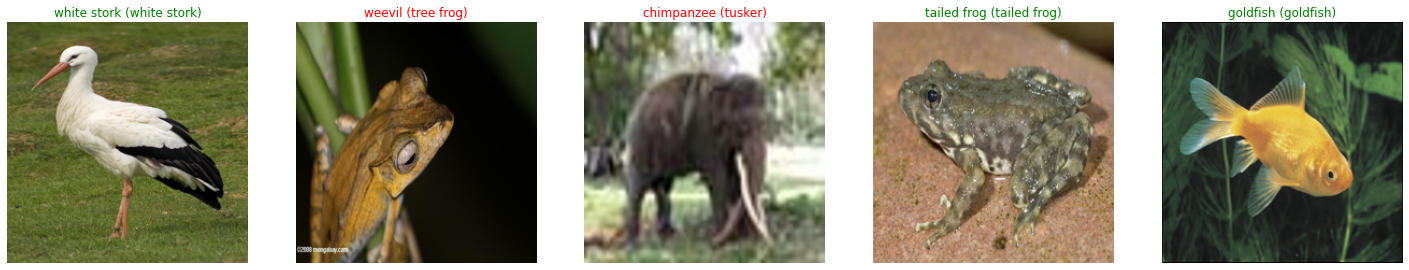

In [ ]:
ivy.set_backend("torch")
device = "gpu:0"
batch_shape = [1]
img_dims = [224, 224]
queries_dim = 1024
learn_query = [True]
load_weights = True
normalize_images=False
preds = perceiver_io_img_classification(path_to_images, normalize_images, device, batch_shape, img_dims, queries_dim, learn_query,
                                         load_weights)

show_results(path_to_images, preds, ground_truth)

### ....with tensorflow backend

2022-11-03 20:04:33.817437: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


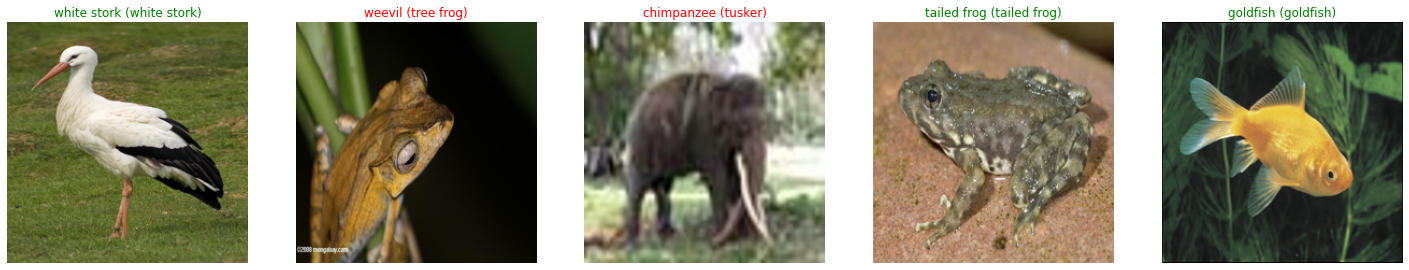

In [ ]:
ivy.set_backend("tensorflow")
device = "gpu:0"
batch_shape = [1]
img_dims = [224, 224]
queries_dim = 1024
learn_query = [True]
load_weights = True
normalize_images=False
preds = perceiver_io_img_classification(path_to_images, normalize_images, device, batch_shape, img_dims, queries_dim, learn_query,
                                         load_weights)

show_results(path_to_images, preds, ground_truth)

### ...with jax backend

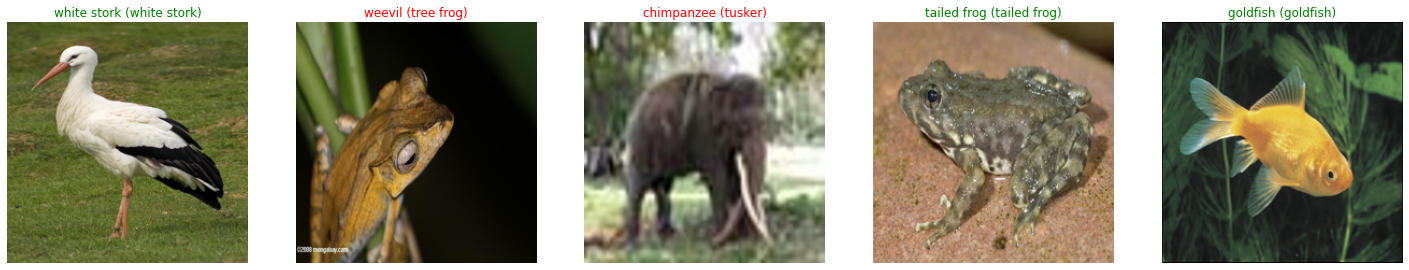

In [ ]:
ivy.set_backend("jax")
device = "gpu:0"
batch_shape = [1]
img_dims = [224, 224]
queries_dim = 1024
learn_query = [True]
load_weights = True
normalize_images=False
preds = perceiver_io_img_classification(path_to_images, normalize_images, device, batch_shape, img_dims, queries_dim, learn_query,
                                         load_weights)

show_results(path_to_images, preds, ground_truth)

### ...with numpy backend

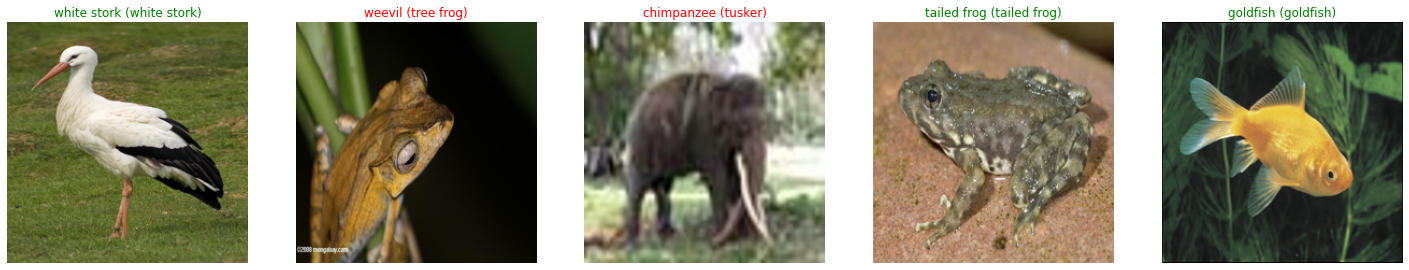

In [ ]:
ivy.set_backend("numpy")
device = "cpu"
batch_shape = [1]
img_dims = [224, 224]
queries_dim = 1024
learn_query = [True]
load_weights = True
normalize_images=False
preds = perceiver_io_img_classification(path_to_images, normalize_images, device, batch_shape, img_dims, queries_dim, learn_query,
                                         load_weights)

show_results(path_to_images, preds, ground_truth)